### Load packages

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import fnmatch
import csv
import pickle

### Required for building NN ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

### Import ZLP data

In [5]:
for file_name in os.listdir('Data/'):
    if fnmatch.fnmatch(file_name, '*.dat'):
        print(file_name)

ZLP_200 keV_2ms_008.dat
ZLP_200 keV_2ms_009.dat
01.dat
ZLP_200 keV_2ms_007.dat
ZLP_200 keV_2ms_006.dat
ZLP_200 keV_2ms_010.dat
ZLP_200 keV_2ms_004.dat
ZLP_200 keV_2ms_005.dat
ZLP_200 keV_2ms_002.dat
ZLP_200 keV_2ms_003.dat



 ***************************************************** 



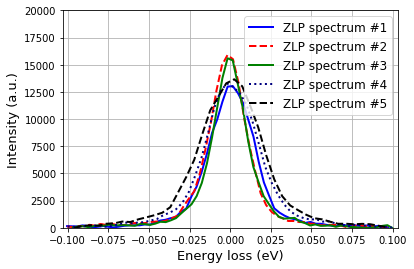

In [6]:
%run EELS-ZLP.py

## Neural Network

### Build architecture

In [60]:
inputsize = len(EELSData_intensity_zlp_3)
outputsize = inputsize

model = tf.keras.Sequential([
    keras.layers.Flatten(input_shape=(inputsize,1)),
    keras.layers.Dense(3, activation='relu'),
    keras.layers.Dense(outputsize)
])

model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy', 'mse', 'mae', 'mape'])




## Prepare trainings data 

In [61]:
y_train = EELSData_intensity_zlp_3
x_train = EELSData_Eloss_3
N_train = 10000

vector = np.ones(N_train)
x_train =  np.swapaxes( (np.reshape(vector,[N_train,1, 1]) * x_train), 1, 2)
y_train = np.swapaxes( (np.reshape(vector,[N_train,1, 1]) * y_train), 1, 2)

### Normalization
y_max = np.max(y_train, axis=1)
y_train_norm = np.divide(y_train, y_max[:, None, :])
y_train_norm = np.squeeze(y_train_norm, axis=2)

### Show sample of training data

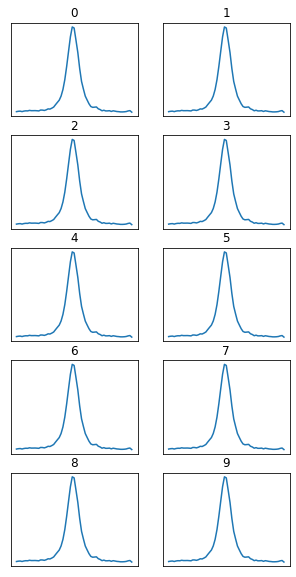

In [62]:
plt.figure(figsize=(5,10))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.plot(x_train[i], y_train_norm[i])
    plt.title(i)
plt.show()

## Training

In [63]:
loss = model.fit(x_train, y_train_norm, batch_size = 5, epochs=10)

Epoch 1/10
10000/10000 [==============================] - 2s 184us/sample - loss: 0.0491 - acc: 0.0000e+00 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1148 - mean_absolute_percentage_error: 458.0431
Epoch 2/10
10000/10000 [==============================] - 2s 171us/sample - loss: 0.0129 - acc: 0.0000e+00 - mean_squared_error: 0.0129 - mean_absolute_error: 0.0653 - mean_absolute_percentage_error: 516.5774s - loss: 0.0149 - acc: 0.0000e+00 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0701 - mean_absolute_percentage_error:
Epoch 3/10
10000/10000 [==============================] - 2s 175us/sample - loss: 0.0032 - acc: 0.0000e+00 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0355 - mean_absolute_percentage_error: 380.4849
Epoch 4/10
10000/10000 [==============================] - 2s 170us/sample - loss: 8.0452e-04 - acc: 0.2340 - mean_squared_error: 8.0452e-04 - mean_absolute_error: 0.0185 - mean_absolute_percentage_error: 229.6530
Epoch 5/10
10000/10000 [=========

In [40]:
hist_df = pd.DataFrame(loss.history) 
#save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
loss_data = pd.read_csv('history.csv')['loss']
acc_data = pd.read_csv('history.csv')['acc']
mse_data = pd.read_csv('history.csv')['mean_squared_error']
mae_data = pd.read_csv('history.csv')['mean_absolute_error']
ape_data = pd.read_csv('history.csv')['mean_absolute_percentage_error']


### Plot outputs

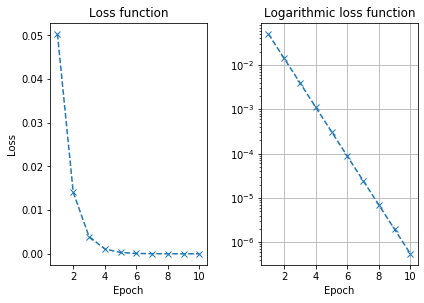

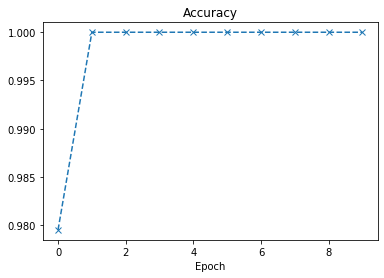

In [59]:
plt.figure()
plt.subplot(121)
plt.plot(np.linspace(1,10,10), loss_data,'x--')
#plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss function')

plt.subplot(122)
plt.plot(np.linspace(1,10,10), loss_data,'x--')
plt.yscale('log')
plt.grid(True)
plt.xlabel('Epoch')
plt.title('Logarithmic loss function')
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)
plt.show()

plt.plot(acc_data,'x--')
plt.xlabel('Epoch')
plt.title('Accuracy')
plt.show()
